# 00__preprocess

in this notebook, i upload all individual library/primer sgRNA counts and sum together (after checking correlations) to make 1 dataframe with all sgRNA counts across populations (Day Zero, Endo++, Endo--). i also convert counts to cpms for downstream analyses

figures in this notebook:
- Fig S5B (heatmap showing biological replicate correlations of sgRNA counts)

In [1]:
import warnings
warnings.filterwarnings('ignore')

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import seaborn as sns
import sys

from ast import literal_eval
from scipy import stats
from scipy.stats import spearmanr

# import utils
sys.path.append("../../../utils")
from plotting_utils import *

%matplotlib inline
%config InlineBackend.figure_format = 'svg'
mpl.rcParams['figure.autolayout'] = False

In [2]:
sns.set(**PAPER_PRESET)
fontsize = PAPER_FONTSIZE

## functions

In [3]:
def to_cpm(df):
    cpm = pd.DataFrame()
    cpm["sgRNA"] = df["sgRNA"]
    for col in df.columns:
        if col not in ["sgRNA"]:
            cpm[col] = df[col]/np.nansum(df[col])*1e6
    return cpm

In [4]:
def pseudocount(df):
    pseudo = pd.DataFrame()
    pseudo["sgRNA"] = df["sgRNA"]
    for col in df.columns:
        if col not in ["sgRNA"]:
            pseudo[col] = df[col] + 1
    return pseudo

## variables

In [5]:
# day zero
day0_lib1_rep1_a_f = "../../../data/02__screen/00__counts/CRISPRi__DayZero__Rep1__Lib1__SetA.sgRNA_counts.txt"
day0_lib1_rep1_b_f = "../../../data/02__screen/00__counts/CRISPRi__DayZero__Rep1__Lib1__SetB.sgRNA_counts.txt"
day0_lib2_rep1_a_f = "../../../data/02__screen/00__counts/CRISPRi__DayZero__Rep1__Lib2__SetA.sgRNA_counts.txt"
day0_lib2_rep1_b_f = "../../../data/02__screen/00__counts/CRISPRi__DayZero__Rep1__Lib2__SetB.sgRNA_counts.txt"
day0_lib3_rep1_a_f = "../../../data/02__screen/00__counts/CRISPRi__DayZero__Rep1__Lib3__SetA.sgRNA_counts.txt"
day0_lib3_rep1_b_f = "../../../data/02__screen/00__counts/CRISPRi__DayZero__Rep1__Lib3__SetB.sgRNA_counts.txt"

day0_lib1_rep2_a_f = "../../../data/02__screen/00__counts/CRISPRi__DayZero__Rep2__Lib1__SetA.sgRNA_counts.txt"
day0_lib1_rep2_b_f = "../../../data/02__screen/00__counts/CRISPRi__DayZero__Rep2__Lib1__SetB.sgRNA_counts.txt"
day0_lib2_rep2_a_f = "../../../data/02__screen/00__counts/CRISPRi__DayZero__Rep2__Lib2__SetA.sgRNA_counts.txt"
day0_lib2_rep2_b_f = "../../../data/02__screen/00__counts/CRISPRi__DayZero__Rep2__Lib2__SetB.sgRNA_counts.txt"
day0_lib3_rep2_a_f = "../../../data/02__screen/00__counts/CRISPRi__DayZero__Rep2__Lib3__SetA.sgRNA_counts.txt"

In [6]:
# BFP+ endo++
bfppos_endopos_lib1_rep1_a_f = "../../../data/02__screen/00__counts/CRISPRi__EndoPos__Rep1__Lib1__SetA.sgRNA_counts.txt"
bfppos_endopos_lib1_rep1_b_f = "../../../data/02__screen/00__counts/CRISPRi__EndoPos__Rep1__Lib1__SetB.sgRNA_counts.txt"
bfppos_endopos_lib2_rep1_a_f = "../../../data/02__screen/00__counts/CRISPRi__EndoPos__Rep1__Lib2__SetA.sgRNA_counts.txt"
bfppos_endopos_lib2_rep1_b_f = "../../../data/02__screen/00__counts/CRISPRi__EndoPos__Rep1__Lib2__SetB.sgRNA_counts.txt"

bfppos_endopos_rep2_a_f = "../../../data/02__screen/00__counts/CRISPRi__EndoPos__Rep2__Lib1__SetA.sgRNA_counts.txt"
bfppos_endopos_rep2_b_f = "../../../data/02__screen/00__counts/CRISPRi__EndoPos__Rep2__Lib1__SetB.sgRNA_counts.txt"

In [7]:
# BFP+ endo--
bfppos_endoneg_lib1_rep1_a_f = "../../../data/02__screen/00__counts/CRISPRi__EndoNeg__Rep1__Lib1__SetA.sgRNA_counts.txt"
bfppos_endoneg_lib2_rep1_a_f = "../../../data/02__screen/00__counts/CRISPRi__EndoNeg__Rep1__Lib2__SetA.sgRNA_counts.txt"


bfppos_endoneg_rep2_a_f = "../../../data/02__screen/00__counts/CRISPRi__EndoNeg__Rep2__Lib1__SetA.sgRNA_counts.txt"
bfppos_endoneg_rep2_b_f = "../../../data/02__screen/00__counts/CRISPRi__EndoNeg__Rep2__Lib1__SetB.sgRNA_counts.txt"

In [8]:
index_f = "../../../data/01__design/02__final_sgRNAs/crispri.clean_index.txt"

## 1. load data

In [9]:
day0_lib1_rep1_a = pd.read_table(day0_lib1_rep1_a_f, sep="\t")
day0_lib1_rep1_b = pd.read_table(day0_lib1_rep1_b_f, sep="\t")
day0_lib2_rep1_a = pd.read_table(day0_lib2_rep1_a_f, sep="\t")
day0_lib2_rep1_b = pd.read_table(day0_lib2_rep1_b_f, sep="\t")
day0_lib3_rep1_a = pd.read_table(day0_lib3_rep1_a_f, sep="\t")
day0_lib3_rep1_b = pd.read_table(day0_lib3_rep1_b_f, sep="\t")

day0_rep1 = day0_lib1_rep1_a.merge(day0_lib1_rep1_b, 
                                   on="sgRNA").merge(day0_lib2_rep1_a, 
                                                     on="sgRNA").merge(day0_lib2_rep1_b, 
                                                                       on="sgRNA").merge(day0_lib3_rep1_a,
                                                                                         on="sgRNA").merge(day0_lib3_rep1_b,
                                                                                                           on="sgRNA")

day0_rep1.columns = ["sgRNA", "lib1_rep1_a", "lib1_rep1_b", "lib2_rep1_a", "lib2_rep1_b", "lib3_rep1_a", "lib3_rep1_b"]
day0_rep1.sort_values(by="sgRNA").head()

,sgRNA,lib1_rep1_a,lib1_rep1_b,lib2_rep1_a,lib2_rep1_b,lib3_rep1_a,lib3_rep1_b
106888,AAAAAAAAAAAAAAAATGAC,80,107,47,52,39,14
82970,AAAAAAAAAAAAAAAGAGTG,8,7,0,25,0,0
51258,AAAAAAAAAAAAAATGAGCT,44,64,42,28,0,49
8731,AAAAAAAAAAAAAATTAGCC,26,7,32,24,0,3
3164,AAAAAAAAAAAAAGGTGCAG,65,5,27,31,0,1


In [10]:
day0_lib1_rep2_a = pd.read_table(day0_lib1_rep2_a_f, sep="\t")
day0_lib1_rep2_b = pd.read_table(day0_lib1_rep2_b_f, sep="\t")
day0_lib2_rep2_a = pd.read_table(day0_lib2_rep2_a_f, sep="\t")
day0_lib2_rep2_b = pd.read_table(day0_lib2_rep2_b_f, sep="\t")
day0_lib3_rep2_a = pd.read_table(day0_lib3_rep2_a_f, sep="\t")

day0_rep2 = day0_lib1_rep2_a.merge(day0_lib1_rep2_b, 
                                   on="sgRNA").merge(day0_lib2_rep2_a, 
                                                     on="sgRNA").merge(day0_lib2_rep2_b, 
                                                                       on="sgRNA").merge(day0_lib3_rep2_a, 
                                                                                         on="sgRNA")

day0_rep2.columns = ["sgRNA", "lib1_rep2_a", "lib1_rep2_b", "lib2_rep2_a", "lib2_rep2_b", "lib3_rep2_a"]
day0_rep2.sort_values(by="sgRNA").head()

,sgRNA,lib1_rep2_a,lib1_rep2_b,lib2_rep2_a,lib2_rep2_b,lib3_rep2_a
28677,AAAAAAAAAAAAAAAATGAC,104,20,40,48,70
52034,AAAAAAAAAAAAAAAGAGTG,2,0,2,0,4
79399,AAAAAAAAAAAAAATGAGCT,38,8,22,4,25
108008,AAAAAAAAAAAAAATTAGCC,28,7,37,5,28
10125,AAAAAAAAAAAAAGGTGCAG,40,4,13,24,45


In [11]:
bfppos_endopos_lib1_rep1_a = pd.read_table(bfppos_endopos_lib1_rep1_a_f, sep="\t")
bfppos_endopos_lib1_rep1_b = pd.read_table(bfppos_endopos_lib1_rep1_b_f, sep="\t")
bfppos_endopos_lib2_rep1_a = pd.read_table(bfppos_endopos_lib2_rep1_a_f, sep="\t")
bfppos_endopos_lib2_rep1_b = pd.read_table(bfppos_endopos_lib2_rep1_b_f, sep="\t")
bfppos_endopos_rep2_a = pd.read_table(bfppos_endopos_rep2_a_f, sep="\t")
bfppos_endopos_rep2_b = pd.read_table(bfppos_endopos_rep2_b_f, sep="\t")

bfppos_endopos_rep1 = bfppos_endopos_lib1_rep1_a.merge(bfppos_endopos_lib1_rep1_b, 
                                                       on="sgRNA").merge(bfppos_endopos_lib2_rep1_a,
                                                                         on="sgRNA").merge(bfppos_endopos_lib2_rep1_b,
                                                                                           on="sgRNA")
bfppos_endopos_rep2 = bfppos_endopos_rep2_a.merge(bfppos_endopos_rep2_b, on="sgRNA")

bfppos_endopos_rep1.columns = ["sgRNA", "lib1_rep1_a", "lib1_rep1_b", "lib2_rep1_a", "lib2_rep1_b"]
bfppos_endopos_rep2.columns = ["sgRNA", "lib1_rep2_a", "lib1_rep2_b"]
bfppos_endopos_rep1.sort_values(by="sgRNA").head()

,sgRNA,lib1_rep1_a,lib1_rep1_b,lib2_rep1_a,lib2_rep1_b
78890,AAAAAAAAAAAAAAAATGAC,429,55,0,11
10890,AAAAAAAAAAAAAAAGAGTG,40,8,0,0
16898,AAAAAAAAAAAAAATGAGCT,314,60,3,8
42078,AAAAAAAAAAAAAATTAGCC,130,19,1,0
103653,AAAAAAAAAAAAAGGTGCAG,73,16,0,1


In [12]:
bfppos_endoneg_lib1_rep1_a = pd.read_table(bfppos_endoneg_lib1_rep1_a_f, sep="\t")
bfppos_endoneg_lib2_rep1_a = pd.read_table(bfppos_endoneg_lib2_rep1_a_f, sep="\t")
bfppos_endoneg_rep2_a = pd.read_table(bfppos_endoneg_rep2_a_f, sep="\t")
bfppos_endoneg_rep2_b = pd.read_table(bfppos_endoneg_rep2_b_f, sep="\t")

bfppos_endoneg_rep1 = bfppos_endoneg_lib1_rep1_a.merge(bfppos_endoneg_lib2_rep1_a, on="sgRNA")
bfppos_endoneg_rep2 = bfppos_endoneg_rep2_a.merge(bfppos_endoneg_rep2_b, on="sgRNA")

bfppos_endoneg_rep1.columns = ["sgRNA", "lib1_rep1_a", "lib2_rep1_a"]
bfppos_endoneg_rep2.columns = ["sgRNA", "lib1_rep2_a", "lib1_rep2_b"]
bfppos_endoneg_rep1.sort_values(by="sgRNA").head()

,sgRNA,lib1_rep1_a,lib2_rep1_a
5461,AAAAAAAAAAAAAAAATGAC,353,95
5069,AAAAAAAAAAAAAAAGAGTG,0,0
43561,AAAAAAAAAAAAAATGAGCT,350,108
86659,AAAAAAAAAAAAAATTAGCC,0,0
105996,AAAAAAAAAAAAAGGTGCAG,0,0


In [13]:
index = pd.read_table(index_f, sep="\t")

## 2. compare technical replicates

In [14]:
all_dfs = {"Day__Zero": [day0_rep1, day0_rep2], "BFP+__Endo++": [bfppos_endopos_rep1, bfppos_endopos_rep2], 
           "BFP+__Endo--": [bfppos_endoneg_rep1, bfppos_endoneg_rep2]}

for name in all_dfs:
    dfs = all_dfs[name]
    for i, df in enumerate(dfs):
        cols = [x for x in df.columns if x != "sgRNA"]
        
        # log transform data for plotting
        tmp = df.copy()
        tmp[cols] = np.log10(tmp[cols] + 1)
        
        # compare A & B seq from same library
        uniq_libs = list(set([x[:-2] for x in cols]))
        
        # edit cols for heatmap below
        new_cols = ["sgRNA"]
        cols = ["%s__%s" % (name, x) for x in cols]
        new_cols.extend(cols)
        df.columns = new_cols
        
        if "Endo--" in name and i == 0:
            continue
        
        for lib in uniq_libs:
            if "lib3" in lib:
                continue
                
            print("%s, rep %s, lib: %s" % (name, i+1, lib))
            col1 = "%s_a" % lib
            col2 = "%s_b" % lib
            
#             # plot
#             g = sns.jointplot(tmp[col1], tmp[col2], color="gray", size=2.2,
#                               marginal_kws=dict(bins=15),
#                               joint_kws=dict(s=5, rasterized=True))
#             g.set_axis_labels("log10(%s (Set A) + 1) counts" % lib, "log10(%s (Set B) + 1) counts" % lib)
            
#             # correlation
#             r, p = spearmanr(tmp[col1], tmp[col2])
#             g.ax_joint.annotate( "r = {:.2f}".format(r), ha="left", xy=(0.1, .90), xycoords=g.ax_joint.transAxes, 
#                                 fontsize=fontsize)

#             #g.savefig("%s_%s_lib_corr_scatter.pdf" % (name, lib), dpi="figure", bbox_inches="tight")
#             plt.show()

Day__Zero, rep 1, lib: lib1_rep1
Day__Zero, rep 1, lib: lib2_rep1
Day__Zero, rep 2, lib: lib1_rep2
Day__Zero, rep 2, lib: lib2_rep2
BFP+__Endo++, rep 1, lib: lib1_rep1
BFP+__Endo++, rep 1, lib: lib2_rep1
BFP+__Endo++, rep 2, lib: lib1_rep2
BFP+__Endo--, rep 2, lib: lib1_rep2


In [15]:
bfppos_counts = day0_rep1.merge(day0_rep2, on="sgRNA").merge(bfppos_endopos_rep1, on="sgRNA").merge(bfppos_endopos_rep2, on="sgRNA").merge(bfppos_endoneg_rep1, on="sgRNA").merge(bfppos_endoneg_rep2, on="sgRNA")

In [16]:
bfppos_counts.set_index("sgRNA", inplace=True)
bfppos_counts.sum(axis=0)

Day__Zero__lib1_rep1_a        37859800
Day__Zero__lib1_rep1_b        25923176
Day__Zero__lib2_rep1_a        32411077
Day__Zero__lib2_rep1_b        20224421
Day__Zero__lib3_rep1_a        10987923
Day__Zero__lib3_rep1_b         8340718
Day__Zero__lib1_rep2_a        44026581
Day__Zero__lib1_rep2_b        14140184
Day__Zero__lib2_rep2_a        35233590
Day__Zero__lib2_rep2_b        11895769
Day__Zero__lib3_rep2_a        38357590
BFP+__Endo++__lib1_rep1_a    170077428
BFP+__Endo++__lib1_rep1_b     27038914
BFP+__Endo++__lib2_rep1_a      9716734
BFP+__Endo++__lib2_rep1_b      7291603
BFP+__Endo++__lib1_rep2_a     62770650
BFP+__Endo++__lib1_rep2_b     35665619
BFP+__Endo--__lib1_rep1_a    124210296
BFP+__Endo--__lib2_rep1_a     21782455
BFP+__Endo--__lib1_rep2_a     85706132
BFP+__Endo--__lib1_rep2_b     55122277
dtype: int64

In [17]:
bfppos_counts_corr = bfppos_counts.corr(method="spearman")

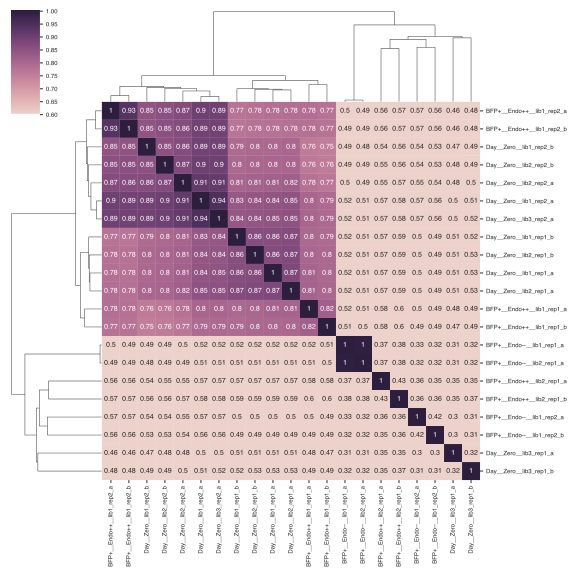

In [18]:
cmap = sns.cubehelix_palette(as_cmap=True)
cg = sns.clustermap(bfppos_counts_corr, figsize=(8, 8), cmap=cmap, annot=False, vmin=0.6)
_ = plt.setp(cg.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
#plt.suptitle("spearman correlation of all replicates (incl technical)\ncounts of all barcodes")
#cg.savefig("BFP+_COUNTS__rep_and_lib_corr_heatmap.pdf", dpi="figure", bbox_inches="tight")

just checking to make sure there's no mistake (two tech reps w/ perfect spearman correlations are not identical)

In [19]:
bfppos_counts[["BFP+__Endo--__lib1_rep1_a", "BFP+__Endo--__lib2_rep1_a"]].sample(5)

,BFP+__Endo--__lib1_rep1_a,BFP+__Endo--__lib2_rep1_a
sgRNA,,
TCCAAAGCAACTGAAATTGG,0,0
CGCTCTTGCCTCACTCTCAG,1659,275
AGTCAATAACTTCGTACATA,611,95
GCGGCAGCAAGGCTGGGGGA,0,0
TCAACATGGATCTCTGCTGT,3729,782


## 3. sum technical replicates

### day 0

In [20]:
day0_rep1["lib1_rep1"] = day0_rep1["Day__Zero__lib1_rep1_a"] + day0_rep1["Day__Zero__lib1_rep1_b"]
day0_rep1.drop(["Day__Zero__lib1_rep1_a", "Day__Zero__lib1_rep1_b"], axis=1, inplace=True)

day0_rep1["lib2_rep1"] = day0_rep1["Day__Zero__lib2_rep1_a"] + day0_rep1["Day__Zero__lib2_rep1_b"]
day0_rep1.drop(["Day__Zero__lib2_rep1_a", "Day__Zero__lib2_rep1_b"], axis=1, inplace=True)

day0_rep1["lib3_rep1"] = day0_rep1["Day__Zero__lib3_rep1_a"] + day0_rep1["Day__Zero__lib3_rep1_b"]
day0_rep1.drop(["Day__Zero__lib3_rep1_a", "Day__Zero__lib3_rep1_b"], axis=1, inplace=True)

day0_rep1["Day_Zero__rep1"] = day0_rep1["lib1_rep1"] + day0_rep1["lib2_rep1"] + day0_rep1["lib3_rep1"]

day0_rep1.drop(["lib1_rep1", "lib2_rep1", "lib3_rep1"], axis=1, inplace=True)
day0_rep1.head()

,sgRNA,Day_Zero__rep1
0,TTATCTGCATACTTATACAG,728
1,TATGCTTTATCCACTCCGAC,1016
2,TGAAAGCATAGGATATGGCA,1859
3,AATGGTAAGTTGCTGCTCAG,961
4,TAAGCATGCGTGGTATCAAG,2257


In [21]:
day0_rep2["lib1_rep2"] = day0_rep2["Day__Zero__lib1_rep2_a"] + day0_rep2["Day__Zero__lib1_rep2_b"]
day0_rep2.drop(["Day__Zero__lib1_rep2_a", "Day__Zero__lib1_rep2_b"], axis=1, inplace=True)

day0_rep2["lib2_rep2"] = day0_rep2["Day__Zero__lib2_rep2_a"] + day0_rep2["Day__Zero__lib2_rep2_b"]
day0_rep2.drop(["Day__Zero__lib2_rep2_a", "Day__Zero__lib2_rep2_b"], axis=1, inplace=True)

day0_rep2["Day_Zero__rep2"] = day0_rep2["lib1_rep2"] + day0_rep2["lib2_rep2"] + day0_rep2["Day__Zero__lib3_rep2_a"]
day0_rep2.drop(["lib1_rep2", "lib2_rep2", "Day__Zero__lib3_rep2_a"], axis=1, inplace=True)
day0_rep2.head()

,sgRNA,Day_Zero__rep2
0,ATCTTACAAGGTGTCTAGCC,1054
1,TGCCCATCATCTGGGATATG,1740
2,CCCCGAGGAGGGCGGCGCCC,2384
3,AAAAAAAACATATTTGGGCC,219
4,AGTTTCTCCCCATGAAAAAT,1853


In [22]:
day0 = day0_rep1.merge(day0_rep2, on="sgRNA")
day0.head()

,sgRNA,Day_Zero__rep1,Day_Zero__rep2
0,TTATCTGCATACTTATACAG,728,637
1,TATGCTTTATCCACTCCGAC,1016,1206
2,TGAAAGCATAGGATATGGCA,1859,2038
3,AATGGTAAGTTGCTGCTCAG,961,925
4,TAAGCATGCGTGGTATCAAG,2257,1383


### BFP+ endo++

In [23]:
bfppos_endopos_rep1["BFP+_Endo++__rep1"] = bfppos_endopos_rep1["BFP+__Endo++__lib1_rep1_a"] + bfppos_endopos_rep1["BFP+__Endo++__lib1_rep1_b"] + bfppos_endopos_rep1["BFP+__Endo++__lib2_rep1_a"] + bfppos_endopos_rep1["BFP+__Endo++__lib2_rep1_b"]

bfppos_endopos_rep1.drop(["BFP+__Endo++__lib1_rep1_a", "BFP+__Endo++__lib1_rep1_b", "BFP+__Endo++__lib2_rep1_a", "BFP+__Endo++__lib2_rep1_b"], axis=1, inplace=True)

bfppos_endopos_rep2["BFP+_Endo++__rep2"] = bfppos_endopos_rep2["BFP+__Endo++__lib1_rep2_a"] + bfppos_endopos_rep2["BFP+__Endo++__lib1_rep2_b"]
bfppos_endopos_rep2.drop(["BFP+__Endo++__lib1_rep2_a", "BFP+__Endo++__lib1_rep2_b"], axis=1, inplace=True)

bfppos_endopos = bfppos_endopos_rep1.merge(bfppos_endopos_rep2, on="sgRNA")
bfppos_endopos.head()

,sgRNA,BFP+_Endo++__rep1,BFP+_Endo++__rep2
0,GACCCGAAACCGTCCCCGGC,5686,2896
1,GCGGTTTAGCCGCTAGTCAA,1759,1147
2,TCGCTGAGAGCAGGAAACTA,1374,1013
3,TAGAATACTCAGGCCAGCCT,2317,673
4,CGGGCGACCTGGGCACCAGC,1883,951


### BFP+ endo--

In [24]:
bfppos_endoneg_rep1["BFP+_Endo--__rep1"] = bfppos_endoneg_rep1["BFP+__Endo--__lib1_rep1_a"] + bfppos_endoneg_rep1["BFP+__Endo--__lib2_rep1_a"]
bfppos_endoneg_rep1.drop(["BFP+__Endo--__lib1_rep1_a", "BFP+__Endo--__lib2_rep1_a"], axis=1, inplace=True)

bfppos_endoneg_rep2["BFP+_Endo--__rep2"] = bfppos_endoneg_rep2["BFP+__Endo--__lib1_rep2_a"] + bfppos_endoneg_rep2["BFP+__Endo--__lib1_rep2_b"]
bfppos_endoneg_rep2.drop(["BFP+__Endo--__lib1_rep2_a", "BFP+__Endo--__lib1_rep2_b"], axis=1, inplace=True)

bfppos_endoneg = bfppos_endoneg_rep1.merge(bfppos_endoneg_rep2, on="sgRNA")
bfppos_endoneg.head()

,sgRNA,BFP+_Endo--__rep1,BFP+_Endo--__rep2
0,CCGGAAAGCGCTGGTCTAGC,63,734
1,TGGAGCCTCGGAATACAGCC,2831,524
2,AGAGAAACAAGCCCTTTAAA,132,939
3,CTGGATGTGAATCCCAGGTC,630,1386
4,AGGGCGGCCGGAAGTGGCGT,0,255


## 4. compare biological replicates

In [25]:
bfppos_counts = day0.merge(bfppos_endopos, on="sgRNA").merge(bfppos_endoneg, on="sgRNA")

In [26]:
tmp = bfppos_counts.set_index("sgRNA")
tmp.columns = ["Day Zero (rep 1)", "Day Zero (rep 2)", "Differentiated (rep 1)", "Differentiated (rep 2)",
               "Undifferentiated (rep 1)", "Undifferentiated (rep 2)"]
bfppos_counts_corr = tmp.corr(method="spearman")

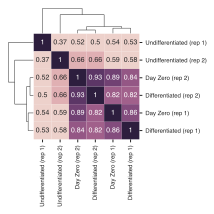

In [27]:
cg = sns.clustermap(bfppos_counts_corr, figsize=(3, 3), cmap=cmap, annot=True, vmin=0.6, **{"cbar": False})
cg.cax.set_visible(False)
_ = plt.setp(cg.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
#plt.suptitle("spearman correlation of all replicates\ncounts of all barcodes")
cg.savefig("FigS5A.pdf", dpi="figure", bbox_inches="tight")

In [28]:
len(bfppos_counts)

111801

## 5. report read count sums across conditions

In [29]:
bfppos_counts[["Day_Zero__rep1", "Day_Zero__rep2", "BFP+_Endo++__rep1", "BFP+_Endo++__rep2",
               "BFP+_Endo--__rep1", "BFP+_Endo--__rep2"]].sum(axis=0)

Day_Zero__rep1       135747115
Day_Zero__rep2       143653714
BFP+_Endo++__rep1    214124679
BFP+_Endo++__rep2     98436269
BFP+_Endo--__rep1    145992751
BFP+_Endo--__rep2    140828409
dtype: int64

## 6. write counts file for DESeq2 input

In [30]:
# write summed counts to file for DESeq2
bfppos_counts.columns = ["sgRNA", "DZ_Rep1", "DZ_Rep2", "Pos_Rep1", "Pos_Rep2", "Neg_Rep1", "Neg_Rep2"]
bfppos_counts.to_csv("../../../data/02__screen/00__counts/Biol_Reps.sgRNA_counts.txt", sep="\t", index=False)

## 7. normalize counts to cpm for downstream analyses

In [31]:
all_norm_counts = pseudocount(bfppos_counts)
all_norm_counts = to_cpm(all_norm_counts)
all_norm_counts.head()

,sgRNA,DZ_Rep1,DZ_Rep2,Pos_Rep1,Pos_Rep2,Neg_Rep1,Neg_Rep2
0,TTATCTGCATACTTATACAG,5.365861,4.437782,4.303655,4.272027,0.006844,3.724984
1,TATGCTTTATCCACTCCGAC,7.485707,8.395616,8.191882,7.448142,4.524157,2.469132
2,TGAAAGCATAGGATATGGCA,13.690673,14.182817,11.860725,10.817056,11.847680,7.130683
3,AATGGTAAGTTGCTGCTCAG,7.080875,6.441044,9.624878,7.701825,10.074977,8.897390
4,TAAGCATGCGTGGTATCAAG,16.620183,9.626787,11.944744,9.355840,8.562362,0.007095


In [32]:
len(all_norm_counts)

111801

## 8. join w/ index & write full table

In [33]:
data = bfppos_counts.merge(all_norm_counts, on="sgRNA", suffixes=("__counts", "__cpm"))
print(len(data))
data.head()

111801


,sgRNA,DZ_Rep1__counts,DZ_Rep2__counts,Pos_Rep1__counts,Pos_Rep2__counts,Neg_Rep1__counts,Neg_Rep2__counts,DZ_Rep1__cpm,DZ_Rep2__cpm,Pos_Rep1__cpm,Pos_Rep2__cpm,Neg_Rep1__cpm,Neg_Rep2__cpm
0,TTATCTGCATACTTATACAG,728,637,921,420,0,524,5.365861,4.437782,4.303655,4.272027,0.006844,3.724984
1,TATGCTTTATCCACTCCGAC,1016,1206,1754,733,660,347,7.485707,8.395616,8.191882,7.448142,4.524157,2.469132
2,TGAAAGCATAGGATATGGCA,1859,2038,2540,1065,1730,1004,13.690673,14.182817,11.860725,10.817056,11.847680,7.130683
3,AATGGTAAGTTGCTGCTCAG,961,925,2061,758,1471,1253,7.080875,6.441044,9.624878,7.701825,10.074977,8.897390
4,TAAGCATGCGTGGTATCAAG,2257,1383,2558,921,1250,0,16.620183,9.626787,11.944744,9.355840,8.562362,0.007095


In [34]:
index.columns

Index(['sgRNA', 'count', 'tss_id_hg38', 'transcript_id', 'transcript_name',
       'gene_id', 'gene_name', 'tss_type', 'cage_id_hg19', 'sgRNA_qual',
       'cut_offset', 'rank', 'sgRNA_id', 'ctrl_status', 'oligo', 'oligo_len',
       'csf_status', 'gene_biotype_status', 'transcript_biotype_status',
       'ctrl_status_fixed'],
      dtype='object')

In [35]:
index_sub = index[["sgRNA", "tss_id_hg38", "transcript_id", "transcript_name", "gene_id", "gene_name",
                   "tss_type", "cage_id_hg19", "rank", "ctrl_status_fixed", "transcript_biotype_status",
                   "sgRNA_id"]]
len(index_sub)

111801

In [36]:
index_sub["refseq"] = index_sub["tss_id_hg38"].str.split(":", expand=True)[0]
index_sub["tss_start_hg38"] = index_sub["tss_id_hg38"].str.split(":", expand=True)[2]
index_sub["tss_strand_hg38"] = index_sub["tss_id_hg38"].str.split(":", expand=True)[1]

In [37]:
f = "../../../misc/05__refseq/chr_to_refseq.txt"
refseq = pd.read_table(f, sep="\t", header=None)
refseq.columns = ["tss_chr_hg38", "refseq"]

In [38]:
index_sub = index_sub.merge(refseq, on="refseq", how="left")
len(index_sub)

111801

In [39]:
def fix_starts(row):
    if row["ctrl_status_fixed"] == "scramble":
        return np.nan
    elif "," in row["tss_start_hg38"]:
        all_ids = literal_eval(row["tss_id_hg38"])
        s = []
        for i in all_ids:
            start = i.split(":")[2]
            s.append(start)
        return s
    else:
        return row["tss_start_hg38"]
    
index_sub["tss_start_hg38"] = index_sub.apply(fix_starts, axis=1)
index_sub[pd.isnull(index_sub["tss_chr_hg38"])]       

,sgRNA,tss_id_hg38,transcript_id,transcript_name,gene_id,gene_name,tss_type,cage_id_hg19,rank,ctrl_status_fixed,transcript_biotype_status,sgRNA_id,refseq,tss_start_hg38,tss_strand_hg38,tss_chr_hg38
886,CCCCGGCCCGAGCCGCCTGG,"['NC_000001.11:+:120844396', 'NC_000001.11:-:1...","['ENST00000427732.1', 'ENST00000455105.1']","['RP11-763B22.4-001', 'RP11-89F3.2-001']","['ENSG00000236140.1', 'ENSG00000237343.1']","['RP11-763B22.4', 'RP11-89F3.2']",FANTOM CAT assignment,"['chr1:148760484..148760496,+', 'chr1:14824810...","[9.0, 10.0]",experimental,intergenic,sgRNA:038563__gene:multiple,['NC_000001.11,"[120844396, 148529246]",+,NaN
898,CAGCTCAGGAAGATGACTCA,"['NC_000001.11:-:120931', 'NC_000001.11:-:2975...","['ENST00000424587.6_1', 'ENST00000466430.5_1',...","['RP11-34P13.7-001', 'AP006222.2-001', 'AC1379...","['ENSG00000260923.5_1', 'ENSG00000238009.6_2',...","['RP11-34P13.7', 'AP006222.2', 'AC137934.1']",annotation,none,"[1.0, 8.0, 1.0]",experimental,multi-targeting,sgRNA:032588__gene:multiple,['NC_000001.11,"[120931, 297501, 90185997]",-,NaN
899,TCAGCTAGAAAAAAATTAAG,"['NC_000001.11:-:120931', 'NC_000001.11:-:2975...","['ENST00000424587.6_1', 'ENST00000466430.5_1',...","['RP11-34P13.7-001', 'AP006222.2-001', 'AC1379...","['ENSG00000260923.5_1', 'ENSG00000238009.6_2',...","['RP11-34P13.7', 'AP006222.2', 'AC137934.1']",annotation,none,"[3.0, 10.0, 3.0]",experimental,multi-targeting,sgRNA:088334__gene:multiple,['NC_000001.11,"[120931, 297501, 90185997]",-,NaN
900,TCAGCTCAGGAAGATGACTC,"['NC_000001.11:-:120931', 'NC_000001.11:-:2975...","['ENST00000424587.6_1', 'ENST00000466430.5_1',...","['RP11-34P13.7-001', 'AP006222.2-001', 'AC1379...","['ENSG00000260923.5_1', 'ENSG00000238009.6_2',...","['RP11-34P13.7', 'AP006222.2', 'AC137934.1']",annotation,none,"[2.0, 9.0, 2.0]",experimental,multi-targeting,sgRNA:088336__gene:multiple,['NC_000001.11,"[120931, 297501, 90185997]",-,NaN
901,AAATTAAGAGGAAAATCACA,"['NC_000001.11:-:120931', 'NC_000016.10:+:9018...","['ENST00000466430.5_1', 'ENST00000568418.1_1']","['RP11-34P13.7-001', 'AC137934.1-005']","['ENSG00000260923.5_1', 'ENSG00000238009.6_2']","['RP11-34P13.7', 'AC137934.1']",annotation,none,"[9.0, 8.0]",experimental,transcript_overlap,sgRNA:002916__gene:multiple,['NC_000001.11,"[120931, 90185997]",-,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111796,TTTAGCTTAGGCCTTAATGG,scramble,scramble,scramble,scramble,scramble,NaN,NaN,10,scramble,NaN,sgRNA:096541__scrambled:09,scramble,NaN,None,NaN
111797,TTTAGTGAGGCGCGGACCGT,scramble,scramble,scramble,scramble,scramble,NaN,NaN,10,scramble,NaN,sgRNA:010970__scrambled:09,scramble,NaN,None,NaN
111798,TTTATAGTAAAAGGTCGTTT,scramble,scramble,scramble,scramble,scramble,NaN,NaN,10,scramble,NaN,sgRNA:097696__scrambled:09,scramble,NaN,None,NaN
111799,TTTCGAGAGAATTGGCCGGG,scramble,scramble,scramble,scramble,scramble,NaN,NaN,10,scramble,NaN,sgRNA:099195__scrambled:09,scramble,NaN,None,NaN


In [40]:
def fix_null_chrs(row):
    if pd.isnull(row["tss_chr_hg38"]):
        if row["ctrl_status_fixed"] == "scramble":
            return "scramble"
        else:
            all_ids = literal_eval(row["tss_id_hg38"])
            idx = all_ids[0]
            idx_refseq = idx.split(":")[0]
            chrom = refseq[refseq["refseq"] == idx_refseq]["tss_chr_hg38"].iloc[0]
            return chrom
    else:
        return row["tss_chr_hg38"]

index_sub["tss_chr_hg38"] = index_sub.apply(fix_null_chrs, axis=1)
index_sub[pd.isnull(index_sub["tss_chr_hg38"])]    

,sgRNA,tss_id_hg38,transcript_id,transcript_name,gene_id,gene_name,tss_type,cage_id_hg19,rank,ctrl_status_fixed,transcript_biotype_status,sgRNA_id,refseq,tss_start_hg38,tss_strand_hg38,tss_chr_hg38


In [41]:
index_sub = index_sub[["sgRNA", "ctrl_status_fixed", "gene_id", "gene_name", "transcript_id", "transcript_name", 
                       "transcript_biotype_status", "tss_chr_hg38", "tss_start_hg38", "tss_strand_hg38", "tss_type",
                       "tss_id_hg38", "sgRNA_id"]]
index_sub.columns = ["sgRNA", "ctrl_status", "gene_id", "gene_name", "transcript_id", "transcript_name", 
                     "transcript_biotype_status", "tss_chr_hg38", "tss_start_hg38", "tss_strand_hg38", "tss_type",
                     "tss_id_hg38", "sgRNA_id"]
print(len(index_sub))
index_sub.head()

111801


,sgRNA,ctrl_status,gene_id,gene_name,transcript_id,transcript_name,transcript_biotype_status,tss_chr_hg38,tss_start_hg38,tss_strand_hg38,tss_type,tss_id_hg38,sgRNA_id
0,TTGCAAGTGTCTTTAAACTA,experimental,ENSG00000241073.1_2,RP4-714D9.2,ENST00000432294.1_1,RP4-714D9.2-001,transcript_overlap,chr1,100084320,-,FANTOM CAT assignment,NC_000001.11:-:100084320,sgRNA:104025__gene:RP4-714D9.2
1,ATTGCAAGTGTCTTTAAACT,experimental,ENSG00000241073.1_2,RP4-714D9.2,ENST00000432294.1_1,RP4-714D9.2-001,transcript_overlap,chr1,100084320,-,FANTOM CAT assignment,NC_000001.11:-:100084320,sgRNA:027184__gene:RP4-714D9.2
2,AGCCAGTATCTTGAAACTAT,experimental,ENSG00000241073.1_2,RP4-714D9.2,ENST00000432294.1_1,RP4-714D9.2-001,transcript_overlap,chr1,100084320,-,FANTOM CAT assignment,NC_000001.11:-:100084320,sgRNA:017196__gene:RP4-714D9.2
3,TGCCAATAGTTTCAAGATAC,experimental,ENSG00000241073.1_2,RP4-714D9.2,ENST00000432294.1_1,RP4-714D9.2-001,transcript_overlap,chr1,100084320,-,FANTOM CAT assignment,NC_000001.11:-:100084320,sgRNA:095459__gene:RP4-714D9.2
4,ACAGTAGTGTATCTAAATGG,experimental,ENSG00000241073.1_2,RP4-714D9.2,ENST00000432294.1_1,RP4-714D9.2-001,transcript_overlap,chr1,100084320,-,FANTOM CAT assignment,NC_000001.11:-:100084320,sgRNA:009695__gene:RP4-714D9.2


In [42]:
data = index_sub.merge(data, on="sgRNA")
print(len(data))
data.head()

111801


,sgRNA,ctrl_status,gene_id,gene_name,transcript_id,transcript_name,transcript_biotype_status,tss_chr_hg38,tss_start_hg38,tss_strand_hg38,...,Pos_Rep1__counts,Pos_Rep2__counts,Neg_Rep1__counts,Neg_Rep2__counts,DZ_Rep1__cpm,DZ_Rep2__cpm,Pos_Rep1__cpm,Pos_Rep2__cpm,Neg_Rep1__cpm,Neg_Rep2__cpm
0,TTGCAAGTGTCTTTAAACTA,experimental,ENSG00000241073.1_2,RP4-714D9.2,ENST00000432294.1_1,RP4-714D9.2-001,transcript_overlap,chr1,100084320,-,...,574,769,872,1049,6.374260,9.515495,2.683950,7.813446,5.975173,7.449968
1,ATTGCAAGTGTCTTTAAACT,experimental,ENSG00000241073.1_2,RP4-714D9.2,ENST00000432294.1_1,RP4-714D9.2-001,transcript_overlap,chr1,100084320,-,...,1159,482,0,449,3.209212,4.041303,5.414577,4.901161,0.006844,3.192843
2,AGCCAGTATCTTGAAACTAT,experimental,ENSG00000241073.1_2,RP4-714D9.2,ENST00000432294.1_1,RP4-714D9.2-001,transcript_overlap,chr1,100084320,-,...,967,700,0,1080,5.380582,6.378442,4.518371,7.113280,0.006844,7.669919
3,TGCCAATAGTTTCAAGATAC,experimental,ENSG00000241073.1_2,RP4-714D9.2,ENST00000432294.1_1,RP4-714D9.2-001,transcript_overlap,chr1,100084320,-,...,1145,382,516,584,3.098803,3.665691,5.349229,3.886428,3.538562,4.150696
4,ACAGTAGTGTATCTAAATGG,experimental,ENSG00000241073.1_2,RP4-714D9.2,ENST00000432294.1_1,RP4-714D9.2-001,transcript_overlap,chr1,100084320,-,...,2263,679,0,690,8.346894,8.200854,10.567761,6.900186,0.006844,4.902788


In [43]:
data_f = "../../../data/02__screen/01__normalized_counts/Biol_Reps.sgRNA_counts.w_index.txt"
data.to_csv(data_f, sep="\t", index=False)